# In this script I am creating an advanced model named C-RNN for the processed dataset. The C-RNN model is a hybrid of a CNN and an RNN.
-------------------------------------------------------------------------------------------------------------------
# Technology used: Tensorflow

### Start with importing the usual cells for my tasks

In [1]:
# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# for pickling the data
import cPickle as pickle

# THE TensorFlow framework
import tensorflow as tf

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

Data
LICENSE
Models
README.md
Scripts



In [4]:
np.random.seed(3) # set this seed for a device independant consistent behaviour

In [5]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../Data" # the data path

data_files_path = {
    "train": os.path.join(data_path, "train"),
    "test" : os.path.join(data_path, "test")
}

base_model_path = "../Models"
plug_and_play_data_file = os.path.join(data_path, "plug_and_play.pickle")

labels_csv_file = os.path.join(data_path, "labels.csv")

# constants for the preprocessing script
im_dim = 128; n_channels = 3 # RGB images
patch_size = 32 # we look at 32 x 32 sized patches to generate the representation vectors
fixed_resize = (im_dim, im_dim, n_channels)
batch_size = 64 # 64 images in each batch
highest_pixel_value = 255 # since color channels are 8 bits.
train_percentage = 95
representation_vector_length = 128 # length of the representation vector to be fed to the RNN
cell_state_size = 512 # LSTM_cell_size
no_of_epochs = 100
checkpoint_factor = 5 # save model after 5 epochs

# Use the unpickler function from the helpers repository to get the processed data into memory:
link to code -> https://github.com/akanimax/machine-learning-helpers/blob/master/pickling_unpickling/pickling_operations.py

In [6]:
# function to unpickle the given file and load the obj back into the python environment
def unPickleIt(pickle_path): # might throw the file not found exception
    '''
        function to unpickle the object from the given path
        @param
        pickle_path => the path where the pickle file is located
        @return => the object extracted from the saved path
    '''

    with open(pickle_path, 'rb') as dumped_pickle:
        obj = pickle.load(dumped_pickle)

    return obj # return the unpickled object

In [7]:
processed_data = unPickleIt(plug_and_play_data_file)

In [8]:
train_X = processed_data['train_X']
train_Y = processed_data['train_Y']
test_X = processed_data['test_X']
test_Y = processed_data['test_Y']
labels_dict = processed_data['labels_dict']
reverse_labels_dict = processed_data['reverse_labels_dict']

In [9]:
# shape sanity checking
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((9711, 128, 128, 3), (9711, 1), (511, 128, 128, 3), (511, 1))

In [10]:
# extract the number of class labels 
num_labels = len(labels_dict)

# Small code implementation checking:

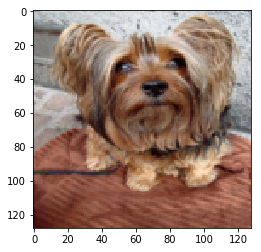

In [26]:
random_index = np.random.randint(train_X.shape[0])
random_image = train_X[random_index]

# plot the entire image in one piece:
plt.imshow(random_image);

# Use tensorflow to extract image patches from this image:

In [69]:
tf.reset_default_graph()

In [70]:
tf_input = tf.placeholder(tf.float32, shape=(None, im_dim, im_dim, n_channels)) # placeholder for holding the image

In [71]:
# use the tf.extract_image_patches function to generate patches of the input image
fixed_patch_size = (1, patch_size, patch_size, 1)
fixed_stride_pattern = (1, (patch_size / 2), (patch_size / 2), 1)
fixed_rates = (1, 1, 1, 1) # don't know what this means yet. I have opened a question on stack overflow for this.
un_pats = tf.extract_image_patches(tf_input, fixed_patch_size, fixed_stride_pattern, fixed_rates, "VALID", "Patcher")

patches = tf.reshape(un_pats, shape=(-1, patch_size, patch_size, n_channels))

In [72]:
un_pats

<tf.Tensor 'Patcher:0' shape=(?, 7, 7, 3072) dtype=float32>

# Use a temporary session to see if the images are getting split into small patches

In [73]:
sess = tf.InteractiveSession()

In [74]:
segments = sess.run(patches, feed_dict={tf_input: np.expand_dims(random_image, axis=0)})

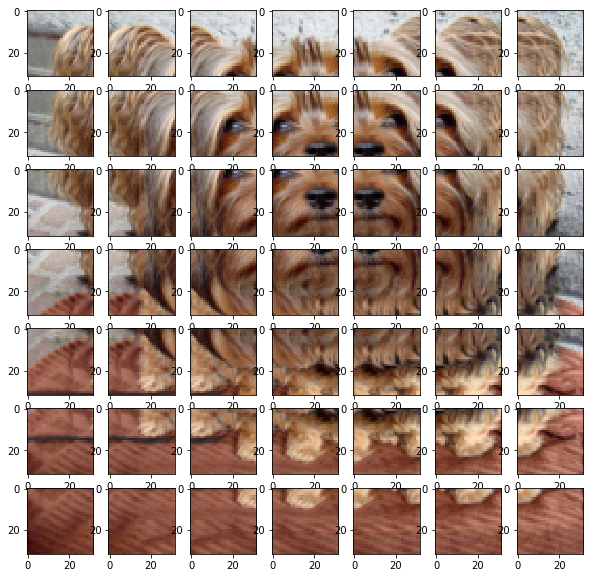

In [75]:
fig, ax = plt.subplots(nrows=7, ncols=7, figsize=(10, 10))

count = 0
for row in ax:
    for col in row:
        col.imshow(segments[count])
        count += 1

In [76]:
# close the session so that we can move forward with creating the actual graph for the task
sess.close()
# reset the graph for being sure:
tf.reset_default_graph()

# Cool! so, we can now generate patches of the given input image and then generate representation vectors through these patches
-------------------------------------------------------------------------------------------------------------------
# Since there are no tied weights experimentation to be done here, I'll directly use the layers api from tensorflow to make the code cleaner

In [158]:
# reset point for the graph:
tf.reset_default_graph()

### Define the input placeholders and the one hot label encoder

In [159]:
# define the placeholders for the input images and their corresponding labels:
with tf.variable_scope("Input_placeholders"):
    tf_input = tf.placeholder(tf.float32, shape=(None, im_dim, im_dim, n_channels), name="Raw_input_images")
    tf_input_summary = tf.summary.image("Input_Images", tf_input, max_outputs=1)
    
    tf_labels = tf.placeholder(tf.int32, shape=(None,), name="Ideal_breed_labels")

In [160]:
# one hot encode the input labels
one_hot_encoded_tf_labels = tf.one_hot(tf_labels, depth=num_labels, axis=1, name="One_hot_Encode")

In [161]:
# check the dimensions and types of the input placeholder:
tf_input, tf_labels, one_hot_encoded_tf_labels

(<tf.Tensor 'Input_placeholders/Raw_input_images:0' shape=(?, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'Input_placeholders/Ideal_breed_labels:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'One_hot_Encode:0' shape=(?, 120) dtype=float32>)

### Define the ops required for creating patches of the input images

In [162]:
def patcher(image):
    '''
        function to generate the fixed size (32 x 32) non overlapping patches of the given input image
        ** The input image needs to be of size 128 x 128.
        @param 
        image => the image of size (128, 128, 3)
        @return => tensor of image patches:
    '''
    fixed_patch_size = (1, patch_size, patch_size, 1)
    fixed_stride_pattern = (1, (patch_size / 2), (patch_size / 2), 1)
    fixed_rates = (1, 1, 1, 1) # don't know what this means yet. I have opened a question on stack overflow for this.
    un_pats = tf.extract_image_patches(image, fixed_patch_size, fixed_stride_pattern, fixed_rates, "VALID", "Patcher")

    patches = tf.reshape(un_pats, shape=(-1, patch_size, patch_size, n_channels))
    
    return patches

In [163]:
# use the tf map function to generate the patches of the given input images
tf_input_patches = tf.map_fn(lambda x: patcher(tf.expand_dims(x, axis=0, name="Expander")), tf_input, name="Patcher")

In [164]:
# extract the sequence length from the tf_input_patches
sequence_length = int(tf_input_patches.get_shape()[1])
print sequence_length

49


In [165]:
# check the dimensions of the patches
print tf_input_patches
summrs = tf.summary.image("Small_patches", tf_input_patches[0], max_outputs=sequence_length)

Tensor("Patcher/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 49, 32, 32, 3), dtype=float32)


### Define the convolutional encoder for generating the representations from the image patches

In [166]:
def convolutional_encode(image_patches, training_mode=False, w_reuse=True):
    '''
        function to encode an image patch of size (32 x 32) into a 128 dimensional vector after performing
        convolutions and pooling operations. Activation function used is ReLU
        @param 
        image_patches => tensor containing the patches of an image
        training_mode => Boolean controlling the training mode of the batch normalization layers
        reuse => Boolean controlling use of same weights or not
        @return => sequence of encoded representations
    '''
    # set a variable scope here so that we end up using the same weights and biases for the infernce mode also:
    with tf.variable_scope("Encoder", reuse=w_reuse):
        # I don't use bias here because the next operation is batchnormalization
        # layer 1
        z1 = tf.layers.conv2d(image_patches, filters=8, kernel_size=(5, 5), 
                                padding="SAME", use_bias=False, name="Conv_layer_1")
        bn_z1 = tf.layers.batch_normalization(z1, axis=3, training=training_mode, name="BN_layer_1")
        
        a1 = tf.nn.relu(bn_z1, name="Relu_layer_1") # activate the values using relu
        
        p1 = tf.layers.max_pooling2d(a1, pool_size=(2, 2), strides=(2, 2), 
                                     padding="SAME", name="MPool_layer_1")
        
        # layer 2
        z2 = tf.layers.conv2d(p1, filters=16, kernel_size=(5, 5), 
                                padding="SAME", use_bias=False, name="Conv_layer_2")
        bn_z2 = tf.layers.batch_normalization(z2, axis=3, training=training_mode, name="BN_layer_2")
        
        a2 = tf.nn.relu(bn_z2, name="Relu_layer_2") # activate the values using relu
        
        # layer 3
        z3 = tf.layers.conv2d(a2, filters=32, kernel_size=(5, 5), 
                                padding="SAME", use_bias=False, name="Conv_layer_3")
        bn_z3 = tf.layers.batch_normalization(z3, axis=3, training=training_mode, name="BN_layer_3")
        
        a3 = tf.nn.relu(bn_z3, name="Relu_layer_3") # activate the values using relu
        
        p3 = tf.layers.max_pooling2d(a3, pool_size=(2, 2), strides=(2, 2), 
                                     padding="SAME", name="MPool_layer_3")
        
        # layer 4
        z4 = tf.layers.conv2d(p3, filters=32, kernel_size=(5, 5), strides=(2, 2),
                                padding="SAME", use_bias=True, name="Conv_layer_4")
        
        z4_1 = tf.layers.conv2d(z4, filters=32, kernel_size=(5, 5), strides=(2, 2),
                                padding="SAME", use_bias=True, name="Conv_layer_4_")
        
        bn_z4_1 = tf.layers.batch_normalization(z4_1, axis=3, training=training_mode, name="BN_layer_4")
        
        a4 = tf.nn.relu(bn_z4_1, name="Relu_layer_4")
        
        # layer for reshaping the activations:
        encoded_representation = tf.reshape(a4, shape=(-1, representation_vector_length), name="Vector_Flattener")
        
    return encoded_representation

### Define the RNN that uses the encoded_representations to model sequences

In [167]:
# The rnn for understanding better spatial dependencies between separate patches of the image

def RNN_predictor(seqs, w_reuse=True):
    '''
        Function for making predictions on the learned representation vectors from the input image
        @param
        seqs => the seqs to make predictions on
        @return => The prediction vector
    '''
    with tf.variable_scope("RNN_Predictor", reuse=w_reuse):
        _, state = tf.nn.dynamic_rnn(
                        tf.nn.rnn_cell.LSTMCell(cell_state_size),
                        seqs, 
                        dtype = tf.float32
                    )
        
        # use the final state to feed into a fully connected layer and obtain the final predictions:
        hd_preds = state.h
        
        unnormalized_final_preds = tf.layers.dense(hd_preds, num_labels, 
                                                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                  activation=tf.nn.relu, name="Projection_layer")
        
    return unnormalized_final_preds

### Define the training computations

In [168]:
with tf.name_scope("Training_computations"):
    # obtain the representations from the mapped patches
    rep_vector = convolutional_encode(
        tf.reshape(tf_input_patches, shape=(-1, patch_size, patch_size, n_channels)), 
            training_mode=True, w_reuse = None)

    reshaped_rep_vector = tf.reshape(rep_vector, shape=(-1, sequence_length, representation_vector_length))
    reshaped_rep_vector_summary = tf.summary.histogram("Representation_vector_activations", reshaped_rep_vector)
    
    # obtain the unnormalized_final_preds
    unnormalized_final_preds = RNN_predictor(reshaped_rep_vector, w_reuse=None)

In [169]:
reshaped_rep_vector

<tf.Tensor 'Training_computations/Reshape_1:0' shape=(?, 49, 128) dtype=float32>

In [170]:
# compare the dimensions of the two cost calculating 
one_hot_encoded_tf_labels, unnormalized_final_preds

(<tf.Tensor 'One_hot_Encode:0' shape=(?, 120) dtype=float32>,
 <tf.Tensor 'Training_computations/RNN_Predictor/Projection_layer/Relu:0' shape=(?, 120) dtype=float32>)

### Define the loss and the trainer ops

In [171]:
with tf.variable_scope("Cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=unnormalized_final_preds,
                                                                 labels=one_hot_encoded_tf_labels), 
                                                                  name="cross_entropy_loss")
    
    cost_summary = tf.summary.scalar("Cost", cost)

In [172]:
with tf.variable_scope("Trainer"):
    
    # manually add the batch_normalization layer's update ops here:
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_step = optimizer.minimize(cost) # This is the training step that uses the Adam optimizer

In [173]:
# print the update_ops to see what exactly they have:
for op in update_ops: print op

Tensor("Training_computations/Encoder/BN_layer_1/AssignMovingAvg:0", shape=(8,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_1/AssignMovingAvg_1:0", shape=(8,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_2/AssignMovingAvg:0", shape=(16,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_2/AssignMovingAvg_1:0", shape=(16,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_3/AssignMovingAvg:0", shape=(32,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_3/AssignMovingAvg_1:0", shape=(32,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_4/AssignMovingAvg:0", shape=(32,), dtype=float32_ref)
Tensor("Training_computations/Encoder/BN_layer_4/AssignMovingAvg_1:0", shape=(32,), dtype=float32_ref)


### Define the inference computations

In [174]:
with tf.name_scope("Inference"):
    # obtain the seq of vectors using the same layers
    seq_vecs = convolutional_encode( tf.reshape(tf_input_patches, shape=(-1, patch_size, patch_size, n_channels)))

    reshaped_seq_vecs = tf.reshape(seq_vecs, shape=(-1, sequence_length, representation_vector_length))
    
    rnn_activations = RNN_predictor(reshaped_seq_vecs)
    
with tf.variable_scope("Predictions"):
    predictions = tf.nn.softmax(rnn_activations)

In [176]:
predictions

<tf.Tensor 'Predictions/Softmax:0' shape=(?, 120) dtype=float32>

### Define the usual errands

In [177]:
with tf.variable_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

# Use a fake session and check if the graph is properly wired using the tensorboard visualizer

In [178]:
model_name = "Model1"
log_dir = os.path.join(base_model_path, model_name)
log_dir

'../Models/Model1'

## Make sure the folder Model1 is empty before executing the following cell, otherwise, it will create duplicate event files and will cause tensorboard to raise warnings.
-------------------------------------------------------------------------------------------------------------------
## I also print out all the trainable variables in the graph to be sure that during inference also, we use the trained variables and not some newly created ones.

In [179]:
with tf.Session() as sess:
    tensorboard_writer = tf.summary.FileWriter(logdir=log_dir, graph=sess.graph, filename_suffix=".bot")
    
    # initialize the session to generate the visualization file
    sess.run(init)
    
    tvars = tf.trainable_variables()
    tvars_vals = sess.run(tvars)
    
    for var, val in zip(tvars, tvars_vals):
        print(var.name)

Encoder/Conv_layer_1/kernel:0
Encoder/BN_layer_1/beta:0
Encoder/BN_layer_1/gamma:0
Encoder/Conv_layer_2/kernel:0
Encoder/BN_layer_2/beta:0
Encoder/BN_layer_2/gamma:0
Encoder/Conv_layer_3/kernel:0
Encoder/BN_layer_3/beta:0
Encoder/BN_layer_3/gamma:0
Encoder/Conv_layer_4/kernel:0
Encoder/Conv_layer_4/bias:0
Encoder/Conv_layer_4_/kernel:0
Encoder/Conv_layer_4_/bias:0
Encoder/BN_layer_4/beta:0
Encoder/BN_layer_4/gamma:0
RNN_Predictor/rnn/lstm_cell/kernel:0
RNN_Predictor/rnn/lstm_cell/bias:0
RNN_Predictor/Projection_layer/kernel:0
RNN_Predictor/Projection_layer/bias:0


# We can now write the session Code for training this graph

## The training loop for this hybrid model:

In [180]:
model_path = log_dir
print os.path.join(model_path, model_name)

../Models/Model1/Model1


In [181]:
num_train_examples = train_X.shape[0]
print num_train_examples

9711


In [182]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. This cell will take a really really long time 
    on low-end machines. It will however not crash your pc, since I have bootstrapped the training in such 
    a way that it loads a small chunk of data at a time to train.
'''

with tf.Session() as sess:
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model1
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    g_step = 0
    for ep in range(no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
            
        for index in range(int(np.ceil(float(num_train_examples) / batch_size))):
            start = index * batch_size
            end = start + batch_size
            minX = train_X[start: end]; minY = np.squeeze(train_Y[start: end])
                
            _, loss = sess.run([train_step, cost], feed_dict={tf_input: minX, tf_labels: minY})
                
            if(index % 50 == 0):
                print('range:{} loss= {}'.format((start, start + len(minX)), loss))
            
            g_step += 1
                
        print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0 or ep == 0):
            
            # calculate the summaries:
            sums = sess.run(all_summaries, feed_dict={tf_input: minX, tf_labels: minY})
            
            # add the summaries to the fileWriter
            tensorboard_writer.add_summary(sums, global_step = g_step)
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, model_name), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

epoch: 1
range:(0, 64) loss= 4.78966999054
range:(3200, 3264) loss= 4.78749132156
range:(6400, 6464) loss= 4.78749132156
range:(9600, 9664) loss= 4.78749132156


epoch: 2
range:(0, 64) loss= 4.78749132156
range:(3200, 3264) loss= 4.78749132156
range:(6400, 6464) loss= 4.78749132156
range:(9600, 9664) loss= 4.78749132156


epoch: 3
range:(0, 64) loss= 4.78749132156
range:(3200, 3264) loss= 4.78749132156
range:(6400, 6464) loss= 4.78749132156
range:(9600, 9664) loss= 4.78749132156


epoch: 4
range:(0, 64) loss= 4.78749132156


KeyboardInterrupt: 